# 1. LSTM 모델 학습 및 정확도 평가
- 하나의 파일을 가지고 학습 후 다른 파일에 적용하는 방식

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [12]:
train_file_path = "./dataset/TW.csv"
train_data = pd.read_csv(train_file_path)

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.1943 - loss: 212.9182 - val_accuracy: 0.4560 - val_loss: 1093.6541
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.2879 - loss: 460.8571 - val_accuracy: 0.3599 - val_loss: 219.8766
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.3349 - loss: 27.8333 - val_accuracy: 0.3391 - val_loss: 68.3826
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.3965 - loss: 29.1269 - val_accuracy: 0.2430 - val_loss: 116.3220
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.3593 - loss: 56.1385 - val_accuracy: 0.3989 - val_loss: 13.8352
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.3706 - loss: 27.8686 - val_accuracy: 0.4261 - val_loss: 15.1229
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4160 - loss: 30.3955 - val_accuracy: 0.3282 - val_loss: 51.4428
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.3996 -

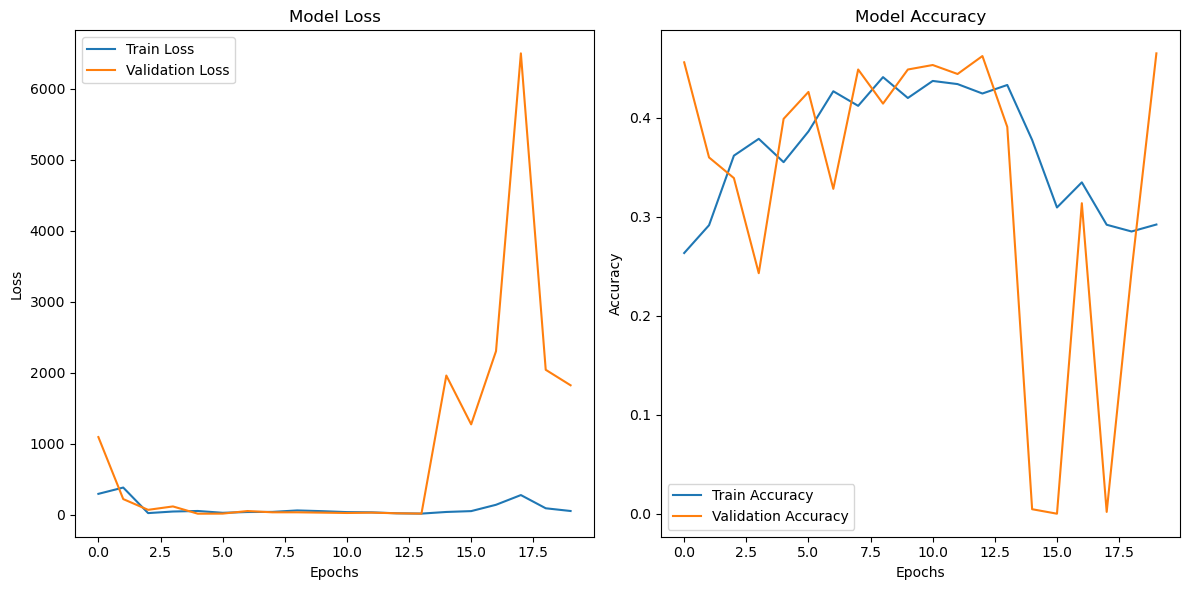

In [14]:
# 2. 데이터 전처리 (필요 컬럼 선택: LAT, LON, HEADING, DESTINATION)
train_data = train_data[['TIMESTAMP', 'VSL_ID', 'LAT', 'LON', 'HEADING', 'DESTINATION']]

# 3. 목적항 인코딩 (DESTINATION)
label_encoder = LabelEncoder()
train_data['DESTINATION'] = label_encoder.fit_transform(train_data['DESTINATION'])

# 4. 선박별 시계열 데이터 생성 (LAT, LON, HEADING만 사용)
def create_sequences(data, seq_length=50):
    sequences = []
    labels = []
    for vsl_id in data['VSL_ID'].unique():
        vessel_data = data[data['VSL_ID'] == vsl_id].sort_values(by='TIMESTAMP')
        
        # 시퀀스 생성
        for i in range(len(vessel_data) - seq_length):
            seq = vessel_data.iloc[i:i+seq_length][['LAT', 'LON', 'HEADING']].values
            label = vessel_data.iloc[i + seq_length]['DESTINATION']
            sequences.append(seq)
            labels.append(label)
    
    return np.array(sequences), np.array(labels)

# 시계열 데이터 생성 (LAT, LON, HEADING만 사용)
X, y = create_sequences(train_data)

# 5. 학습용/검증용 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# 6. LSTM 모델 구축
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # DESTINATION의 클래스 수만큼

# 7. 모델 컴파일
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 8. 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# 9. 모델 평가 (정확도 측정)
loss, accuracy = model.evaluate(X_val, y_val, batch_size=32)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# 10. 학습 과정 시각화 (Loss, Accuracy)
def plot_training_history(history):
    # Loss 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 시각화
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 학습 과정 시각화 호출
plot_training_history(history)
